# Import

In [1]:
# torch package
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# dataset packagea
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

# metrcis
from sklearn.metrics import accuracy_score, classification_report

# ETC
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Simple-GRU Model

## Reset gate

$r_t = \sigma(W_{xr}x_t + b_{xr} + W_{hr}h_{t-1} + b_{hr})$

## Update gate

$z_t = \sigma(W_{xz}x_t + b_{xz} + W_{hz}h_{t-1} + b_{hz})$

## Hidden state

$n_t = tanh(W_{xn}x_t + b_{xn} + r_t * (W_{hn}h_{t-1} + b_{hn}))$

$h_t = (1-z_t) * n_t + z_t * h_{t-1}$

In [2]:
class SimpleGRU_cell(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device


        # reset gate
        self.W_xr = nn.Parameter(torch.empty(self.hidden_size, self.input_size, device=self.device))
        self.W_hr = nn.Parameter(torch.empty(self.hidden_size, self.hidden_size, device=self.device))
        self.b_xr = nn.Parameter(torch.empty(self.hidden_size, device=self.device))
        self.b_hr = nn.Parameter(torch.empty(self.hidden_size, device=self.device))
        nn.init.xavier_uniform_(self.W_xr, gain=hidden_size**-1)
        nn.init.xavier_uniform_(self.W_hr, gain=hidden_size**-1)
        nn.init.constant_(self.b_xr, 1.)
        nn.init.constant_(self.b_hr, 1.)


        # update gate
        self.W_xz = nn.Parameter(torch.empty(self.hidden_size, self.input_size, device=self.device))
        self.W_hz = nn.Parameter(torch.empty(self.hidden_size, self.hidden_size, device=self.device))
        self.b_xz = nn.Parameter(torch.empty(self.hidden_size, device=self.device))
        self.b_hz = nn.Parameter(torch.empty(self.hidden_size, device=self.device))
        nn.init.xavier_uniform_(self.W_xz, gain=hidden_size**-1)
        nn.init.xavier_uniform_(self.W_hz, gain=hidden_size**-1)
        nn.init.constant_(self.b_xz, 1.)
        nn.init.constant_(self.b_hz, 1.)


        # hidden state update
        self.W_xn = nn.Parameter(torch.empty(self.hidden_size, self.input_size, device=self.device))
        self.W_hn = nn.Parameter(torch.empty(self.hidden_size, self.hidden_size, device=self.device))
        self.b_xn = nn.Parameter(torch.empty(self.hidden_size, device=self.device))
        self.b_hn = nn.Parameter(torch.empty(self.hidden_size, device=self.device))
        nn.init.xavier_uniform_(self.W_xn, gain=hidden_size**-1)
        nn.init.xavier_uniform_(self.W_hn, gain=hidden_size**-1)
        nn.init.constant_(self.b_xn, 1.)
        nn.init.constant_(self.b_hn, 1.)




    
    def forward(self, x, hidden=None):
        # init hidden state
        if hidden is None:
            hidden = torch.zeros(x.shape[0], self.hidden_size, device=self.device)


        outputs = []
        for seq in range(x.shape[1]):
            input_x = x[:,seq,:]
            
            reset_ = torch.sigmoid(F.linear(input_x, self.W_xr, self.b_xr) + F.linear(hidden, self.W_hr, self.b_hr)) # reset gate            
            update_ = torch.sigmoid(F.linear(input_x, self.W_xz, self.b_xz) + F.linear(hidden, self.W_hz, self.b_hz)) # update gate
            hidden_temp = torch.tanh(F.linear(input_x, self.W_xn, self.b_xn) + reset_ * F.linear(hidden, self.W_hn, self.b_hn)) # hidden state
            hidden = (1 - update_)*hidden_temp + reset_*hidden # hidden state
            
            outputs.append(hidden.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [3]:
class SimpleGRU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config


        self.embedding = nn.Embedding(num_embeddings=config.vocab_size,
                                     embedding_dim=config.em_output)
        
        # batch_size, sequence_size, embeding_size
        self.gru_1 = SimpleGRU_cell(input_size=config.em_output,
                                    hidden_size=config.gru_node1,
                                    device=config.device
                                    )
        
        self.drop_out = nn.Dropout(p=config.drop_out_rate)
        
        self.gru_2 = SimpleGRU_cell(input_size=config.gru_node1,
                                    hidden_size=config.gru_node2,
                                    device=config.device
                                    )
        
        self.dense = nn.Linear(in_features=config.gru_node2, out_features=1)


    def forward(self, x):
        ebd = self.embedding(x)
        gru1_output = self.gru_1(ebd)
        drop_layer = self.drop_out(gru1_output)
        gru2_output = self.gru_2(drop_layer)
        drop_layer = self.drop_out(gru2_output)
        dense_output = self.dense(drop_layer[:, -1, :])
        sigmoid_output = torch.sigmoid(dense_output)
        # final_output = (sigmoid_output > 0.5).float().view(-1)
        

        return sigmoid_output    

# Train

In [4]:
def train(model, config, train, valid, optimizer=False, loss=False):
    train_loss_history = []
    valid_loss_history = []
    
    optimizer = optimizer if optimizer else optim.Adam(model.parameters(), lr=config.learning_rate)
    loss_function = loss if loss else nn.BCELoss()


    for i in range(config.epochs):

        train_loss_ = 0
        model.train()
        with torch.enable_grad():
            for feature, label in train:
                optimizer.zero_grad()
                outputs = model(feature).view(-1)
                loss = loss_function(outputs, label)
                # loss.requires_grad_(True)
                loss.backward()
                optimizer.step()

                train_loss_ += loss.item()

        train_loss_ /= config.batch_size
        train_loss_history.append(train_loss_)


        valid_loss_ = 0
        model.eval()
        with torch.no_grad():
            for feature, label in valid:
                outputs = model(feature)
                loss = loss_function(outputs.reshape(-1), label)
                
                valid_loss_ += loss.item()

        valid_loss_ /= config.batch_size
        valid_loss_history.append(valid_loss_)

        if (i+1)%int((config.epochs)*0.1)==0:
            print(f"epoch : {i+1} Loss(train) : {train_loss_history[-1]:.3f}  Loss(valid) : {valid_loss_history[-1]:.3f}")


    
    plt.plot(train_loss_history, label='Training loss')
    plt.plot(valid_loss_history, label='Validation loss')
    plt.legend()
    plt.show()
    print("="*40)
    print("Training loss: ", train_loss_history[-1])
    print("Validation loss: ", valid_loss_history[-1])
    print("="*40)

# Predict

In [5]:
def predict_evaluate(model, test):
    model.eval()
    output_list = []
    acc = []

    y_pred = []
    y_test = []
    with torch.no_grad():
        for feature, label in test:
            outputs = model(feature)
            output_list.append(outputs)
            outputs = outputs.cpu()
            outputs = (outputs > 0.5).float().view(-1)

            label = label.cpu()
            acc.append(accuracy_score(label, outputs))
            y_pred.append(outputs)
            y_test.append(label)


    print(f"Accuracy: {(sum(acc)/len(acc)):.3f}")

    return np.array(y_test).reshape(-1), np.array(y_pred).reshape(-1)

# Hyperparameter config

In [6]:
class config():
    def __init__(self, max_size, vocab_size, em_output, gru_node1, gru_node2, drop_out_rate=0.5, learning_rate=0.001, patience_ratio=0.2, epochs=100, 
                 validation_split=0.2, batch_size = 128):
        
        self.vocab_size = vocab_size
        self.em_output = em_output
        self.max_size = max_size

        self.gru_node1 = gru_node1
        self.gru_node2 = gru_node2
        self.drop_out_rate =drop_out_rate
        self.learning_rate = learning_rate
        self.patience = epochs * patience_ratio
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_split = validation_split

        self.device = device

# Dataset

In [7]:
class IMDBDataset(Dataset):
    def __init__(self, X, y, max_size, device):
        X_np = np.array([np.array(xi) for xi in X],dtype=object)
        X_pad = np.zeros((len(X_np), max_size))
        for i in range(len(X)):
            pad_length = min(len(X_np[i]), max_size)
            X_pad[i, :pad_length] = X_np[i][:pad_length]

        self.X = torch.Tensor(X_pad).long().to(device)
        self.y = torch.Tensor(y).to(device)


    def __len__(self):
        return len(self.X)


    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
max_len = 100 # rnn의 장기의존성 이슈 때문에 max_len이 길 경우 학습이 제대로 진행되지 않음
vocab_size = 10000
batch_size = 200

(X_trian, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)
X_train, X_valid, y_train, y_valid = train_test_split(X_trian, y_train, train_size=0.8, stratify=y_train)


train_dataset = IMDBDataset(X_train, y_train, max_len, device=device)
valid_dataset = IMDBDataset(X_valid, y_valid, max_len, device=device)
test_dataset = IMDBDataset(X_test, y_test, max_len, device=device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [9]:
print(f"train shape: {train_dataset.X.shape}")
print(f"valid shape: {valid_dataset.X.shape}")
print(f"test shape : {test_dataset.X.shape}")

train shape: torch.Size([20000, 100])
valid shape: torch.Size([5000, 100])
test shape : torch.Size([25000, 100])


# Model

In [10]:
gru_config = config(vocab_size=vocab_size,
                    max_size=max_len,
                    em_output=64,

                    gru_node1=32,
                    gru_node2=16,

                    drop_out_rate=0.5,
                    learning_rate=0.001,
                    # patience_ratio=0.3,
                    epochs=100,
                    batch_size=batch_size,
                    )

In [11]:
gru = SimpleGRU(gru_config).to(device)

epoch : 10 Loss(train) : 0.145  Loss(valid) : 0.062
epoch : 20 Loss(train) : 0.066  Loss(valid) : 0.088
epoch : 30 Loss(train) : 0.040  Loss(valid) : 0.135
epoch : 40 Loss(train) : 0.027  Loss(valid) : 0.150
epoch : 50 Loss(train) : 0.017  Loss(valid) : 0.429
epoch : 60 Loss(train) : 0.011  Loss(valid) : 0.411
epoch : 70 Loss(train) : 0.009  Loss(valid) : 0.465
epoch : 80 Loss(train) : 0.009  Loss(valid) : 0.499
epoch : 90 Loss(train) : 0.004  Loss(valid) : 0.515
epoch : 100 Loss(train) : 0.002  Loss(valid) : 0.716


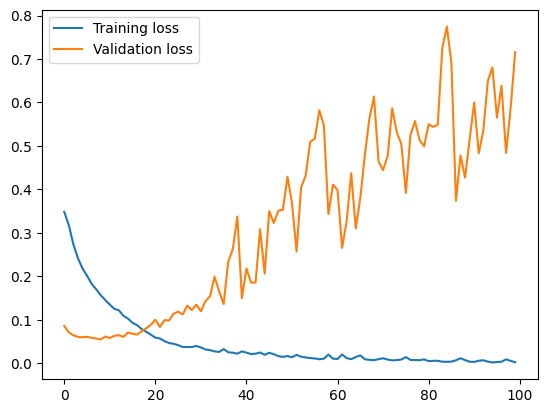

Training loss:  0.0024833011290320427
Validation loss:  0.7161412513256074


In [12]:
train(gru, gru_config, train_loader, valid_loader)

# Evaluation

In [13]:
y_test, y_pred = predict_evaluate(gru, test_loader)

Accuracy: 0.763


In [14]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77     12500
         1.0       0.77      0.75      0.76     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000

